In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt#; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print("Loading MNIST dataset...")
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

Loading MNIST dataset...


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/home/dell/anaconda3/envs/pt1.7/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
for batch in data:
    print(batch[0].shape, batch[1].shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])


### AE model

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.linear1(z))
        return self.linear2(z)

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        x_hat = F.relu(self.linear1(z))
        x_hat = torch.sigmoid(self.linear2(x_hat))
        return x_hat.reshape((-1, 1, 28, 28))

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

encoder: [bs, 1, 28, 28] -> [bs, 784] -> [bs, 512] -> [bs, latent_dims]

decoder: [bs, latent_dims] -> [bs, 512] -> [bs, 784] -> sigmoid, [bs, 784] -> [bs, 1, 28, 28]

In [8]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}")
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [9]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder = train(autoencoder, data)

epoch: 1/20
epoch: 2/20
epoch: 3/20
epoch: 4/20
epoch: 5/20
epoch: 6/20
epoch: 7/20
epoch: 8/20
epoch: 9/20
epoch: 10/20
epoch: 11/20
epoch: 12/20
epoch: 13/20
epoch: 14/20
epoch: 15/20
epoch: 16/20
epoch: 17/20
epoch: 18/20
epoch: 19/20
epoch: 20/20


### plot

In [10]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

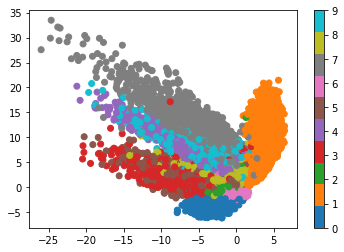

In [11]:
plot_latent(autoencoder, data)

### reconstruction

In [18]:
def plot_reconstructed(autoencoder, r0=(-10, 5), r1=(-5, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
#             print("z: ", z)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

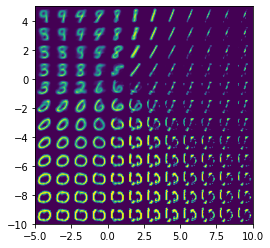

In [19]:
plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12)